# <u><center> Image Classification (Core)
* Authored by: Eric N. Valdez
* Date: 03-22-2024

# Assignment:
- ## For this assignment, you will classify chest X-rays as "normal," "pneumonia," or "covid" using Convolutional Neural Networks.

# <u>Imports:

In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


# <u>Custom Functions

In [3]:

def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f",
                           class_labels=None):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0],
                                           display_labels=class_labels);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=class_labels);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_labels)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)
        
    

    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)

In [ ]:
# Additional Infor from lec

# <u>Making the TensorFlow Image Dataset

In [4]:
# Checking the contents of dataset folder
data_dir = "Data/xrays/"
data_dir

'Data/xrays/'

In [27]:
# Gettting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders

['.ipynb_checkpoints', 'covid']

In [28]:
# # Getting the list of folders in the data_dir
# os.listdir(data_dir)

In [6]:
# Getting list of all img file paths
img_files = glob.glob(data_dir+"**/*")
len(img_files)

531

In [7]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96

In [8]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 495 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [9]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

16

## `Saving Class Info`

In [10]:
# Save the class names for later use
class_names = ds.class_names
class_names

['.ipynb_checkpoints', 'covid']

In [11]:
# Saving # of classes for later use
num_classes = len(class_names)
num_classes

2

In [12]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: '.ipynb_checkpoints', 1: 'covid'}

## `Split the dataset into a training-validation-test split`

In [13]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 11 batches as training data
Use 3 batches as validation data
The remaining 2 batches will be used as test data.


In [14]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
print(f'The training set is {len(train_ds)} batches long.')

The training set is 11 batches long.


In [15]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
print(f'The validation set is {len(val_ds)} batches long.')

The validation set is 3 batches long.


In [16]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
print(f'The testing set is {len(test_ds)} batches long.')

The testing set is 2 batches long.


# <u> `Optimize the Dataset`
- ## Add a shuffle step to the training dataset
- ## Add caching and prefetching to all 3 datasets

In [17]:
import tensorflow as tf

In [18]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#  `Preview the Data and Save the Shape:`

In [19]:
# Get image sizes for later use
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 96, 96, 3])

In [20]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([96, 96, 3])

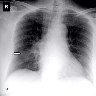

In [21]:
# Preview an image from the Dataset
array_to_img(example_batch_imgs[0])

In [22]:
# Show label value
label = class_dict[np.argmax(example_batch_y[0])]
label

'covid'

# `Modeling`
## <u>Modeling Steps (for every model):
- ### **For every model**
    - ### Fitting the Model
        - using validation_data
        - many epochs (20+)
        - an EarlyStopping callback
        - Save the training history 
- ### **Evaluating the Model:**
    - ### Plot the training history
    - ### Evaluating the model on the training and test data, including:
        - Sckit-learning confusion matrix
        - Sckit-learning classification Report
        - The results from model.evaluate method
            - (`Tip`: Use your custom flexible evaluation functions)

## `1) Build a Simple CNN Model`


In [23]:
# Get early stopping function that can be reused on all models
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [24]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(layers.Conv2D(filters=8, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Convolutional layer
    model.add(layers.Conv2D(filters=8, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(3, activation="softmax")) 

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [25]:
# Build the model
model1 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0

In [26]:
history = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=25,
    callbacks=get_callbacks(),
)

Epoch 1/25


ValueError: in user code:

    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\keras\backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 3) are incompatible


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1,
                                X_train=train_ds,
                                X_test=test_ds,
                                figsize=(9,9),
                                values_format='0.1f',
                                history=history);

**`Evaluation`**
-

## `2) Build a more complex CNN Model`

In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer - additional filters
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # Convolutional layer - additional Conv2D
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    model.add(layers.Conv2D(filters=16, kernel_size=3, input_shape=input_shape, padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))

    # Hidden dense layer
    model.add(layers.Dense(32, activation="relu"))
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(3, activation="softmax")) 

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [ ]:
# Build the model
model_2 = build_model()

In [ ]:
# Obtain and save history for examination
history_2 = model_2.fit(
    train_ds,
    validation_data = val_ds,
    epochs=25,
    callbacks=get_callbacks(),
)

In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model_2,
                                X_train=train_ds,
                                X_test=test_ds,
                                figsize=(9,9),
                                values_format='0.1f',
                                history=history_2);

**`Evaluation`**
-

## `3) Build a Transfer Learning Model using a Keras Application`

In [ ]:
# Download base model
inception_base= tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape)

# Make it not trainable
inception_base.trainable=False
vk.layered_view(inception_base, legend=True)

In [ ]:
# Add preprocessing lambda layer
lambda_layer_inception = tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input, 
                                      name='preprocess_input_inceptv3')


def build_inception_model():
    model = models.Sequential(name="InceptionV3")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_inception)

    # Add pretrained base
    model.add(inception_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [ ]:
# Build, fit, and evaluate EfficientNet Model
model_inception = build_inception_model()
history = model_inception.fit(train_ds, validation_data=val_ds,epochs=20, 
                    callbacks=get_callbacks()
                   )
evaluate_classification_network(model_inception, X_test=test_ds, history=history);

**`Evaluation`**
-

**`Choosing the Best Model`**
-